In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import cv2

from common import Metrics, plot_vessel, load_img
from common import DATA_PATH, X_IMG_PATH, Y_IMG_PATH

In [2]:
THRESHOLD_LABELS_POS = .5
THRESHOLD_PRED_POS = 10

In [3]:
def process_train(path):
    """ Perform train image processing
    
    Removes background, performs some preprocessing operations
    and applies Canny edge detector.
    """
    img = load_img(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find background of image
    th, threshed = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    cnts = cv2.findContours(threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]
    cnts = sorted(cnts, key=cv2.contourArea)

    # Create mask of the background
    mask = np.zeros(img.shape[:2],np.uint8)
    cv2.drawContours(mask, cnts, -1, 255, -1)
    dst = cv2.bitwise_and(img_gray, img_gray, mask=mask)
    
    # Perform dilation in order to remove background artefacts
    kernel9 = np.ones((9, 9), np.uint8)
    dst = cv2.dilate(dst, kernel9, iterations=1)
    mask_out = (dst == 0)
    
    kernel3 = np.ones((3, 3), np.uint8)
    img_gray = cv2.filter2D(img, -1, kernel3 / 9)
    
    # Perform Canny edge detection
    edges = cv2.Canny(img_gray, 20, 100)
    edges_eroded = cv2.dilate(edges, kernel3, iterations=1)
    
    # Remove background from an image and cut off uncertain pixels
    edges_eroded = edges_eroded * mask_out
    edges_offset = edges_eroded > THRESHOLD_PRED_POS
    
    return edges_offset

def process_label(path):
    """ Process label image
    
    Loads image and applies threshold on uncertain pixels.
    """
    img = load_img(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = img_gray > THRESHOLD_LABELS_POS
    return mask

In [4]:
filenames = os.listdir(X_IMG_PATH)
images_orig = [load_img(X_IMG_PATH + fname) for fname in filenames]

In [5]:
y_preds, y_trues = [], []
scores_all = []

for fname in filenames:
    y_pred = process_train(X_IMG_PATH + fname)
    y_true = process_label(Y_IMG_PATH + fname)
    
    scores = Metrics()
    scores.calculate(y_true.ravel(), y_pred.ravel())
    
    y_preds.append(y_pred)
    y_trues.append(y_true)
    scores_all.append(scores)
    
    print(fname, scores)

im0162.ppm Acc: 0.90423, sensitivity: 0.65027, specificity: 0.92372, F1-score: 0.49181
im0139.ppm Acc: 0.91904, sensitivity: 0.24565, specificity: 0.97793, F1-score: 0.32797
im0235.ppm Acc: 0.90890, sensitivity: 0.42752, specificity: 0.95594, F1-score: 0.45520
im0255.ppm Acc: 0.90858, sensitivity: 0.55362, specificity: 0.94347, F1-score: 0.52016
im0004.ppm Acc: 0.92582, sensitivity: 0.00032, specificity: 0.99993, F1-score: 0.00064
im0044.ppm Acc: 0.82911, sensitivity: 0.43026, specificity: 0.85897, F1-score: 0.25965
im0001.ppm Acc: 0.89805, sensitivity: 0.09341, specificity: 0.96783, F1-score: 0.12758
im0081.ppm Acc: 0.91110, sensitivity: 0.37353, specificity: 0.95447, F1-score: 0.38549
im0163.ppm Acc: 0.91215, sensitivity: 0.59323, specificity: 0.93888, F1-score: 0.51087
im0291.ppm Acc: 0.95125, sensitivity: 0.16481, specificity: 0.99314, F1-score: 0.25482
im0082.ppm Acc: 0.90679, sensitivity: 0.59105, specificity: 0.93375, F1-score: 0.49938
im0240.ppm Acc: 0.89866, sensitivity: 0.039

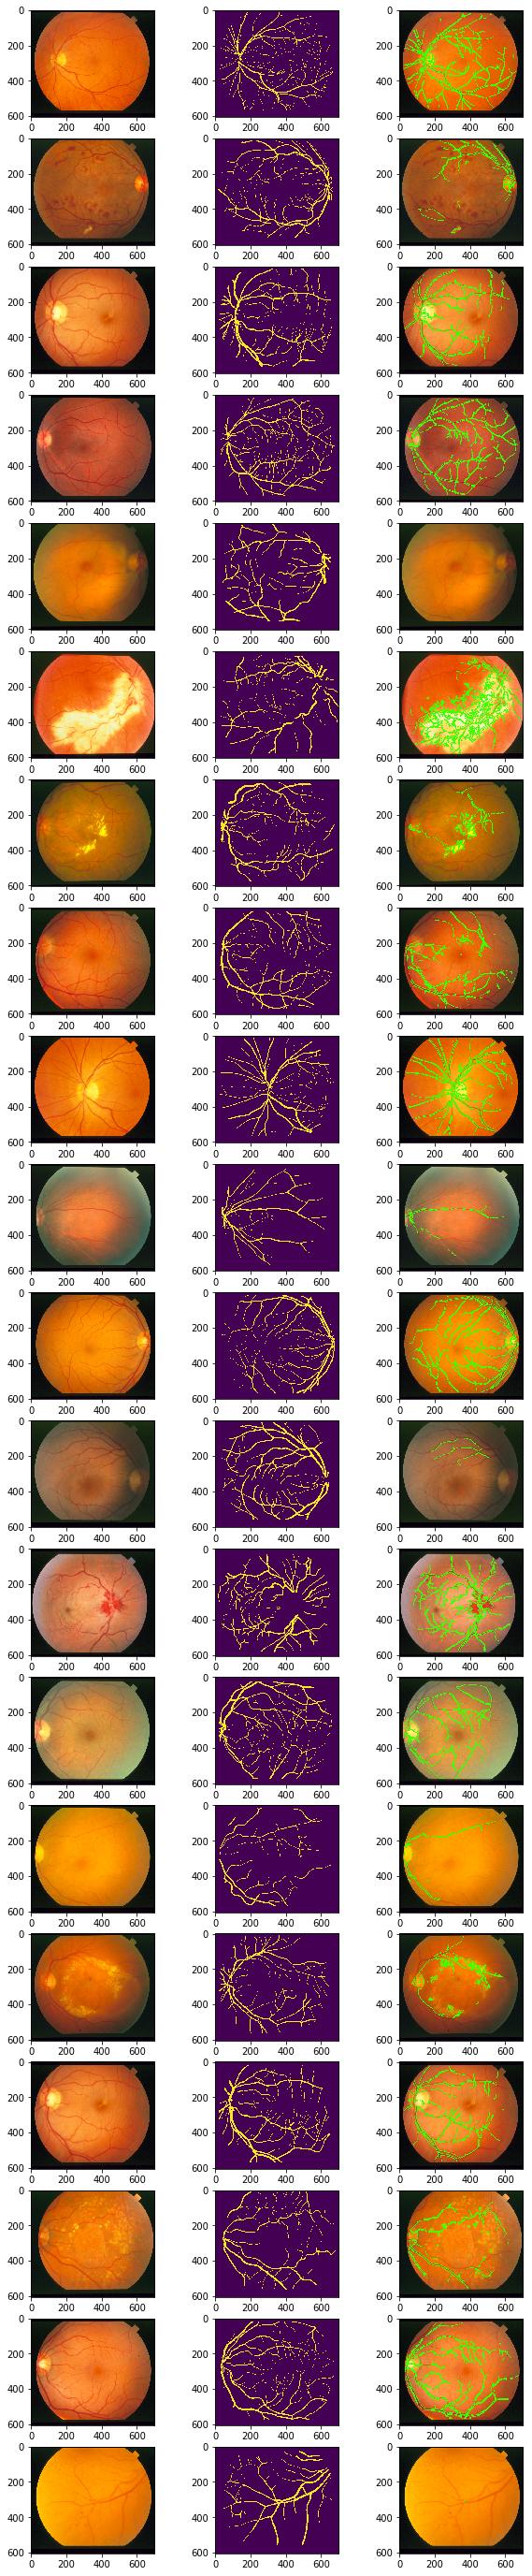

In [6]:
plot_vessel(images_orig, y_trues, y_preds)

In [7]:
metrics_overview = Metrics.mean_metric(scores_all)
print('Mean metrics for {} samples:'.format(len(filenames)))
print(metrics_overview)

Mean metrics for 20 samples:
Acc: 0.91102, sensitivity: 0.33044, specificity: 0.95799, F1-score: 0.32461
